# Современные методы машинного обучения, ИАД

## Семинар 4 - Сверточные нейронные сети

Основа современных глубоких сетей - это два слоя Convolution (сверточный) и Max pooling (взятие максимума)

Convolution:
<img src="https://github.com/Tviskaron/IAD5/blob/master/S4/3.jpg?raw=1">

Max pooling:
<img src="https://github.com/Tviskaron/IAD5/blob/master/S4/Max_pooling.png?raw=1">

### Задание 1

Создадим следующую архитектуру:

![Architecture](https://www.tensorflow.org/images/mnist_deep.png)

In [0]:
import tensorflow as tf
import numpy as np

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [0]:
x = tf.placeholder(tf.float32, shape=[None, 784])

x_image = tf.reshape(x, [-1, 28, 28, 1])

# 1 conv + max_pool
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# 2 conv + max_pool
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)


# 3 flat + fc 
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# 4 dropout + fc
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

Обучим ее на стандартном датасете MNIST, посмотрим точность на тестовой выборке

In [3]:
# supress warnings 
import warnings
warnings.filterwarnings("ignore")

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
y_ = tf.placeholder(tf.float32, [None, 10])

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(2000):
    batch = mnist.train.next_batch(50)
    if i % 100 == 0:
      train_accuracy = accuracy.eval(feed_dict={
          x: batch[0], y_: batch[1], keep_prob: 1.0})
      print('step %d, training accuracy %g' % (i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

  print('test accuracy %g' % accuracy.eval(feed_dict={
      x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

ModuleNotFoundError: No module named 'tensorflow'

### Задание 2 

А теперь поработаем с более сложным датасетом и восопльзуемся еще одной библиотекой-оболочкой - [Keras](https://keras.io).

CIFAR-10 содержит 32x32 цветных изображения 10 классов: __airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__:
<img src="https://github.com/Tviskaron/IAD5/blob/master/S4/cifar10.jpg?raw=1" style="width:80%">

In [4]:
import keras
from keras import backend as K
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Using TensorFlow backend.


1.12.0-rc2
2.1.6
Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


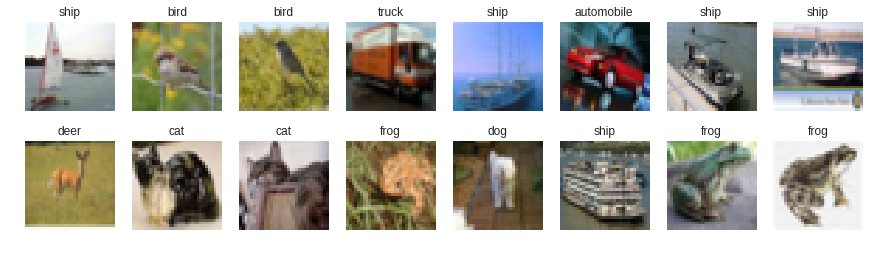

In [5]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

Немного предобработаем наши данные:

Нормализуем картинки: $$x_{norm} = \frac{x}{255} - 0.5$$
и конвертируем метки классов в категориальные (см.  __keras.utils__)

In [0]:
# normalize inputs
x_train2 = x_train / 255 - 0.5
x_test2 = x_test / 255 - 0.5

# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

Строим сеть с использованием Keras:

- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - сверточный слой:
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - взятие максимума.
- [Flatten](https://keras.io/layers/core/#flatten) - слой вытяивания в один вектор.
- [Dense](https://keras.io/layers/core/#dense) - полносвязный слой.
- [Activation](https://keras.io/layers/core/#activation) - применение функции активации.
- [LeakyReLU](https://keras.io/layers/advanced-activations/#leakyrelu) - активация ReLU с утечкой.
- [Dropout](https://keras.io/layers/core/#dropout) - прореживание.

<br>

Наша задача - определить модель, принимающую на вход тензор  __(None, 32, 32, 3)__ и предсказывающую выходной тензор __(None, 10)__, отвечающий за вероятности классов. __None__ стоит на месте размерности подвыборки.

Мы будем строить простую архитектуру вида стакан:

```python
model = Sequential()  # start feed-forward model definition
model.add(Conv2D(..., input_shape=(32, 32, 3)))  # first layer needs to define "input_shape"

...  # here comes a bunch of convolutional, pooling and dropout layers

model.add(Dense(NUM_CLASSES))  # the last layer with neuron for each class
model.add(Activation("softmax"))  # output probabilities
```

Складываем вместе __4__ сверточныйх слоя с размером ядра __(3, 3)__ и с возрастающим количеством фильтров __(16, 32, 32, 64)__, используем "same" смещение (padding).

Добавляем слои максимизации с окном __2x2__  послде каждых двух сверточных слоев (conv-conv-pool схема).

Используем __LeakyReLU__ активацию с параметром утечки __0.1__ для всех слоев, где она применима:
```python
model.add(LeakyReLU(0.1))
```

Добавляем полносвязный слой с __256__ нейронами и второй выходной с __10__ нейронами, соответствующими классам. Не забудьте использовать __Flatten__ слой перед тем, как добавите полносвязные!

Наконец, добавляем слой __Dropout__ после каждого слоя максимизации с параметром прореживания (__0.25__), а после первого полносвязаного - с параметром (__0.5__).

In [0]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    
    # Conv2D + Conv2D + MaxPooling2D + Dropout
    model.add(Conv2D(16, kernel_size=(3,3), padding='same', input_shape=(32, 32, 3)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(32, kernel_size=(3,3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    
    # Conv2D + Conv2D + MaxPooling2D + Dropout
    model.add(Conv2D(32, kernel_size=(3,3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(64, kernel_size=(3,3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    
    # Flatten + fc
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(rate=0.5))
    # fc
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('softmax'))
    
    return model

In [16]:
# скачиваем нужные нам файлы для импорта: tqdm_utils.py + keras_utils.py
!wget -nc https://raw.githubusercontent.com/Tviskaron/IAD5/master/S4/tqdm_utils.py
!wget -nc https://raw.githubusercontent.com/Tviskaron/IAD5/master/S4/keras_utils.py
import keras_utils
from keras_utils import *
from tqdm_utils import *


# describe model
s = reset_tf_session()
model = make_model()
model.summary()

File ‘tqdm_utils.py’ already there; not retrieving.

File ‘keras_utils.py’ already there; not retrieving.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
___________________________________

Нарисуем получившийся граф

In [2]:

from IPython.display import clear_output, Image, display, HTML
import tensorflow as tf
import numpy as np
from google.colab import files

!wget -nc https://raw.githubusercontent.com/Tviskaron/IAD5/master/S4/keras_graph_draw.py
from keras_graph_draw import *
graph_def = tf.get_default_graph().as_graph_def()
show_graph(graph_def)

ModuleNotFoundError: No module named 'tensorflow'

Теперь насталая очередь учить и тестировать нашу модель. В процессе обучения мы хотим наблюдать изменения в функции потерь на валидации.

In [0]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10

s = reset_tf_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

model_filename = 'cifar.{0:03d}.hdf5'
last_finished_epoch = 0

In [0]:
from collections import defaultdict
import numpy as np
from keras.models import save_model
import tensorflow as tf
import keras
from keras import backend as K

from __future__ import print_function
import tqdm
tqdm.monitor_interval = 0  # workaround for https://github.com/tqdm/tqdm/issues/481



In [1]:
# fit model
model.fit(
    x_train2, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory(), 
               TqdmProgressCallback(),
               ModelSaveCallback(model_filename)],
    validation_data=(x_test2, y_test2),
    shuffle=True,
    verbose=0,
    initial_epoch=last_finished_epoch or 0
)

NameError: name 'model' is not defined

Строим матрицу ошибок

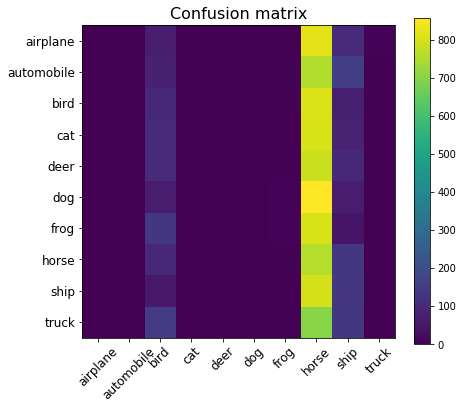

Test accuracy: 0.1003


In [0]:
# make test predictions
y_pred_test = model.predict_proba(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

Проверяем несколько предсказаний

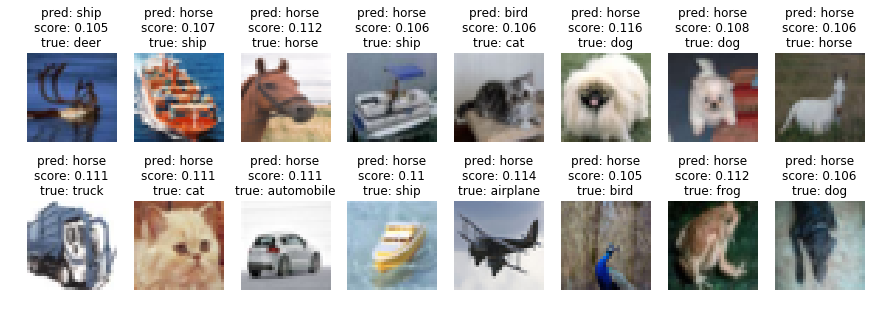

In [0]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index, 0]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()